Maybr buena cosa seria usar GYM en un custom Environment:
- https://towardsdatascience.com/getting-started-with-openai-gym-d2ac911f5cbc
- https://www.gymlibrary.dev/content/environment_creation/
- https://www.gymlibrary.dev/content/vectorising/
- https://blog.paperspace.com/getting-started-with-openai-gym/

El verdadero CHAD: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/9da0471a9eeb2351a488cd4b44fc6bbf/reinforcement_q_learning.ipynb#scrollTo=m_WKkK0sH3Tp


- TEstear arquitecturas de RNN

In [2]:
import sys
import os
from functools import reduce

project_path = os.path.abspath('..')
sys.path.insert(1, project_path)

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import math
import random
from collections import namedtuple, deque
from itertools import count, product
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from src.models.EnvironmentCachos import NPC, Strategic_NPC, AmbienteCacho
from src.models.Agents import AgentTable, Agent, Agent_SARSA, Agent_QLearning
from src.models.utils import train_over_games, play_one_game, plot_winrate, winrate_every, plot_time_per_game, Q_plot, plot_epsilon

## Demostración del Juego con el "Agente Racional"

In [5]:
game_env = AmbienteCacho(2)
placeholder = Strategic_NPC()
play_one_game(game_env, placeholder, verbose = True, graphs = False, NPC=True)

En esta ronda, los jugadores tenían los dados:
[array([0, 0, 1, 2, 1, 1]), array([0, 2, 0, 1, 1, 1])]
El Agente jugó (1, 'Cuadras')
Oponente 1 Played:  (2, 'Cuadras')
El Agente jugó (3, 'Cuadras')
Oponente 1 Played:  Dudo
1 ('Oponente 1 Dudo Mal', 1) (array([0, 0, 1, 2, 1, 1]), [5, 4], (3, 'Cuadras'))
--------------------------------------------------------------------------------
En esta ronda, los jugadores tenían los dados:
[array([0, 2, 1, 0, 1, 1]), array([0, 0, 1, 1, 0, 2])]
El Oponente partió jugando (1, 'Sextas')
El Agente jugó (2, 'Sextas')
Oponente 1 Played:  (3, 'Sextas')
El Agente jugó Dudo
-1 ('Agent Dudo Mal', 0) (array([0, 2, 1, 0, 1, 1]), [4, 4], (3, 'Sextas'))
--------------------------------------------------------------------------------
En esta ronda, los jugadores tenían los dados:
[array([2, 0, 1, 1, 0, 0]), array([0, 0, 0, 1, 0, 3])]
El Agente jugó (1, 'Trenes')
Oponente 1 Played:  (1, 'Sextas')
El Agente jugó (2, 'Sextas')
Oponente 1 Played:  (3, 'Sextas')
El Ag

(-1, None, 0.0)

# Evolución del WinRate a lo largo del aprendizaje

In [6]:
n_games = 1000000
every = n_games//100
gamma = 0.99
epsilon0 = 1
epsdecay = 0.01
epsmin = 0.001
lr = 0.1
scores_dict = {"x": every* np.arange(n_games//every)}
times_dict = {"x": np.arange(n_games)}
epsilon_dict = {"x": np.arange(n_games)}
game_env = AmbienteCacho(2, NPC_type = Strategic_NPC)

## Agente Tabular Entrenado con Monte Carlo Control

In [7]:
agente_MC = AgentTable(gamma = gamma, epsilon = epsilon0, lr = lr, game_env = game_env, eps_end = epsmin, eps_dec = epsdecay, eps_method = "Lineal", name = "Agente MC")
scores, eps_hist, times = train_over_games(game_env, agente_MC, n_games, mode = "Tabular", verbose = False)
print(np.mean(scores))
scores_dict["MC Control"] = winrate_every(scores, every)
times_dict["MC Control"] = times
epsilon_dict["MC Control"] = eps_hist
agente_MC.save_table(project_path+"/models/QTable_AgentMC1M")

----------------------------------------
Creando el Juego 1
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.94
Tiempo por iteración (promedio últimos 100 episodios): 0.0 s
----------------------------------------
Creando el Juego 10001
Resultados Parciales:
Winrate (últimos 100 episodios): 0.03
Epsilon actual: 0.001
Tiempo por iteración (promedio últimos 100 episodios): 0.0016 s
----------------------------------------
Creando el Juego 20001
Resultados Parciales:
Winrate (últimos 100 episodios): 0.15
Epsilon actual: 0.001
Tiempo por iteración (promedio últimos 100 episodios): 0.002 s
----------------------------------------
Creando el Juego 30001
Resultados Parciales:
Winrate (últimos 100 episodios): 0.38
Epsilon actual: 0.001
Tiempo por iteración (promedio últimos 100 episodios): 0.0017 s
----------------------------------------
Creando el Juego 40001
Resultados Parciales:
Winrate (últimos 100 episodios): 0.57
Epsilon actual: 0.001
Tiempo por iteración (pr

KeyboardInterrupt: 

## Agente Tabular Entrenado con SARSA

In [ ]:
agente_SARSA = Agent_SARSA(gamma = gamma, epsilon = epsilon0, lr = lr, game_env = game_env, eps_end = epsmin, eps_dec = epsdecay, eps_method = "Lineal", name = "Agente SARSA")
scores, eps_hist, times = train_over_games(game_env, agente_SARSA, n_games, mode = "1-step", verbose = False)
print(np.mean(scores))
scores_dict["SARSA"] = winrate_every(scores, every)
times_dict["SARSA"] = times
epsilon_dict["SARSA"] = eps_hist

agente_SARSA.save_table(project_path+"/models/QTable_AgentSARSA1M")

## Agente Tabular Entrenado con QLearning

In [ ]:
agente_QLearning = Agent_QLearning(gamma = gamma, epsilon = epsilon0, lr = lr, game_env = game_env, eps_end = epsmin, eps_dec = epsdecay, eps_method = "Lineal", name =  "Agente QLearning")
scores, eps_hist, times = train_over_games(game_env, agente_QLearning, n_games, mode = "1-step", verbose = False)
print(np.mean(scores))
scores_dict["QLearning"] = winrate_every(scores, every)
times_dict["QLearning"] = times
epsilon_dict["QLearning"] = eps_hist

agente_QLearning.save_table(project_path+"/models/QTable_AgentQLearning1M")

In [ ]:
df_wr = pd.DataFrame(scores_dict)
df_times = pd.DataFrame(times_dict)
df_epsilons = pd.DataFrame(epsilon_dict)

In [ ]:
plot_winrate(df_wr, every)

In [ ]:
plot_time_per_game(df_times, m = every)
print(df_times.mean())

In [ ]:
plot_epsilon(df_epsilons, m = every, metodo = "Lineal")

# Guardando las Q_Tables asociadas a los agentes en archivos

NameError: name 'agente_SARSA' is not defined

# Visualización de las Q_Tables

## Cargando Modelos Preentrenados

In [ ]:
agente_MC.load_table(project_path+"/models/QTable_AgentMC")
agente_SARSA.load_table(project_path+"/models/QTable_AgentSARSA")
agente_QLearning.load_table(project_path+"/models/QTable_AgentQLearning")

## Visualizando las tablas de reward por acción en un estado fijo

In [ ]:
estado = ((0,0,0,1,1,1),(3,3), (2, "Trenes"))

In [ ]:
Q_plot(agente_MC, estado)
Q_plot(agente_SARSA, estado)
Q_plot(agente_QLearning, estado)

## Visión del agente al Jugar un Juego:

In [ ]:
play_one_game(game_env, agente_MC, verbose = True, graphs = True, tabular = True)

# Uso de Deep QLearning

In [26]:
n_games = 10000
every = n_games//100
gamma = 0.99
epsilon0 = 1.
epsdecay = 1e-3
lr = 0.001
scores_dict = {"x": every* np.arange(n_games//every)}
times_dict = {"x": np.arange(n_games)}
epsilon_dict = {"x": np.arange(n_games)}
game_env = AmbienteCacho(2, NPC_type = Strategic_NPC)

In [27]:
agente_DQN = Agent(gamma=gamma, epsilon=epsilon0, batch_size=64, game_env= game_env, eps_dec=epsdecay, eps_end=0.001, input_dims=[10], lr=lr)


In [28]:
scores, eps_hist, times = train_over_games(game_env, agente_DQN, n_games, mode = "Deep", Target_Update = 50000, verbose = False)
print(np.mean(scores))
scores_dict["Deep QLearning"] = winrate_every(scores, every)
times_dict["Deep QLearning"] = times
epsilon_dict["Deep QLearning"] = eps_hist

----------------------------------------
Creando el Juego 1
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 1.0
Tiempo por iteración (promedio últimos 100 episodios): 0.0 s
----------------------------------------
Creando el Juego 101
Resultados Parciales:
Winrate (últimos 100 episodios): 0.06
Epsilon actual: 0.09
Tiempo por iteración (promedio últimos 100 episodios): 0.0354 s
----------------------------------------
Creando el Juego 201
Resultados Parciales:
Winrate (últimos 100 episodios): 0.55
Epsilon actual: 0.001
Tiempo por iteración (promedio últimos 100 episodios): 0.0647 s
----------------------------------------
Creando el Juego 301
Resultados Parciales:
Winrate (últimos 100 episodios): 0.81
Epsilon actual: 0.001
Tiempo por iteración (promedio últimos 100 episodios): 0.0695 s
----------------------------------------
Creando el Juego 401
Resultados Parciales:
Winrate (últimos 100 episodios): 0.8
Epsilon actual: 0.001
Tiempo por iteración (promedio últ

----------------------------------------
Creando el Juego 4001
Resultados Parciales:
Winrate (últimos 100 episodios): 0.94
Epsilon actual: 0.001
Tiempo por iteración (promedio últimos 100 episodios): 0.0649 s
----------------------------------------
Creando el Juego 4101
Resultados Parciales:
Winrate (últimos 100 episodios): 0.98
Epsilon actual: 0.001
Tiempo por iteración (promedio últimos 100 episodios): 0.0795 s
----------------------------------------
Creando el Juego 4201
Resultados Parciales:
Winrate (últimos 100 episodios): 0.97
Epsilon actual: 0.001
Tiempo por iteración (promedio últimos 100 episodios): 0.0732 s
--------------------------------------------------------------------------------
Target Updated
--------------------------------------------------------------------------------
----------------------------------------
Creando el Juego 4301
Resultados Parciales:
Winrate (últimos 100 episodios): 0.93
Epsilon actual: 0.001
Tiempo por iteración (promedio últimos 100 episodio

----------------------------------------
Creando el Juego 7901
Resultados Parciales:
Winrate (últimos 100 episodios): 0.95
Epsilon actual: 0.001
Tiempo por iteración (promedio últimos 100 episodios): 0.0849 s
----------------------------------------
Creando el Juego 8001
Resultados Parciales:
Winrate (últimos 100 episodios): 0.94
Epsilon actual: 0.001
Tiempo por iteración (promedio últimos 100 episodios): 0.0846 s
----------------------------------------
Creando el Juego 8101
Resultados Parciales:
Winrate (últimos 100 episodios): 0.98
Epsilon actual: 0.001
Tiempo por iteración (promedio últimos 100 episodios): 0.0958 s
----------------------------------------
Creando el Juego 8201
Resultados Parciales:
Winrate (últimos 100 episodios): 0.97
Epsilon actual: 0.001
Tiempo por iteración (promedio últimos 100 episodios): 0.0916 s
----------------------------------------
Creando el Juego 8301
Resultados Parciales:
Winrate (últimos 100 episodios): 0.98
Epsilon actual: 0.001
Tiempo por iteració

In [29]:
df_wr = pd.DataFrame(scores_dict)
df_times = pd.DataFrame(times_dict)
df_epsilons = pd.DataFrame(epsilon_dict)

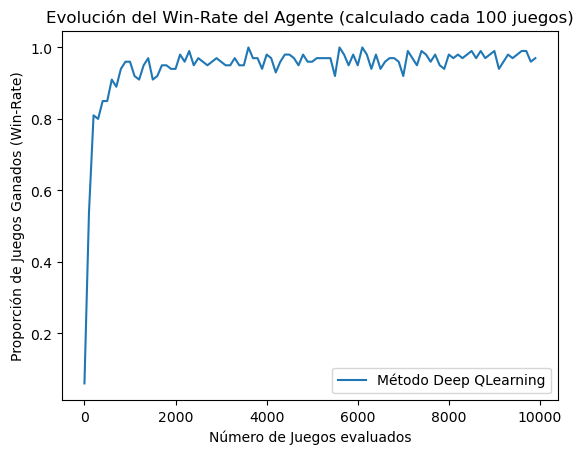

In [30]:
plot_winrate(df_wr, every)

In [39]:
df_times.mean()

x                 4999.500000
Deep QLearning       0.079593
dtype: float64

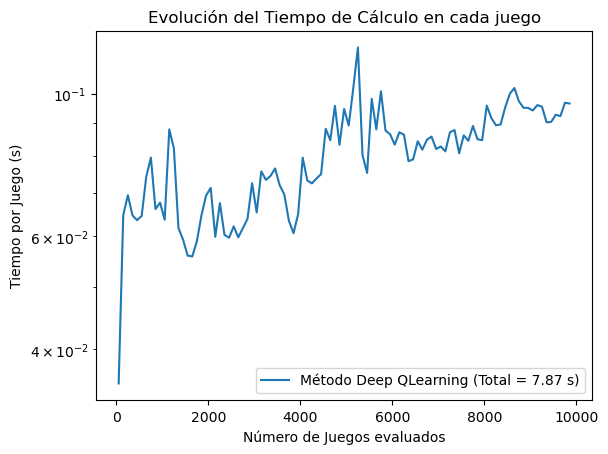

x                 4999.500000
Deep QLearning       0.079593
dtype: float64


In [31]:
plot_time_per_game(df_times, m = every)
print(df_times.mean())

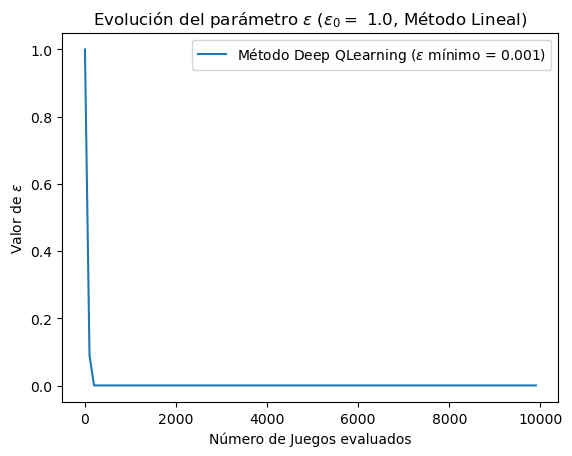

In [32]:
plot_epsilon(df_epsilons, m = every, metodo = "Lineal")

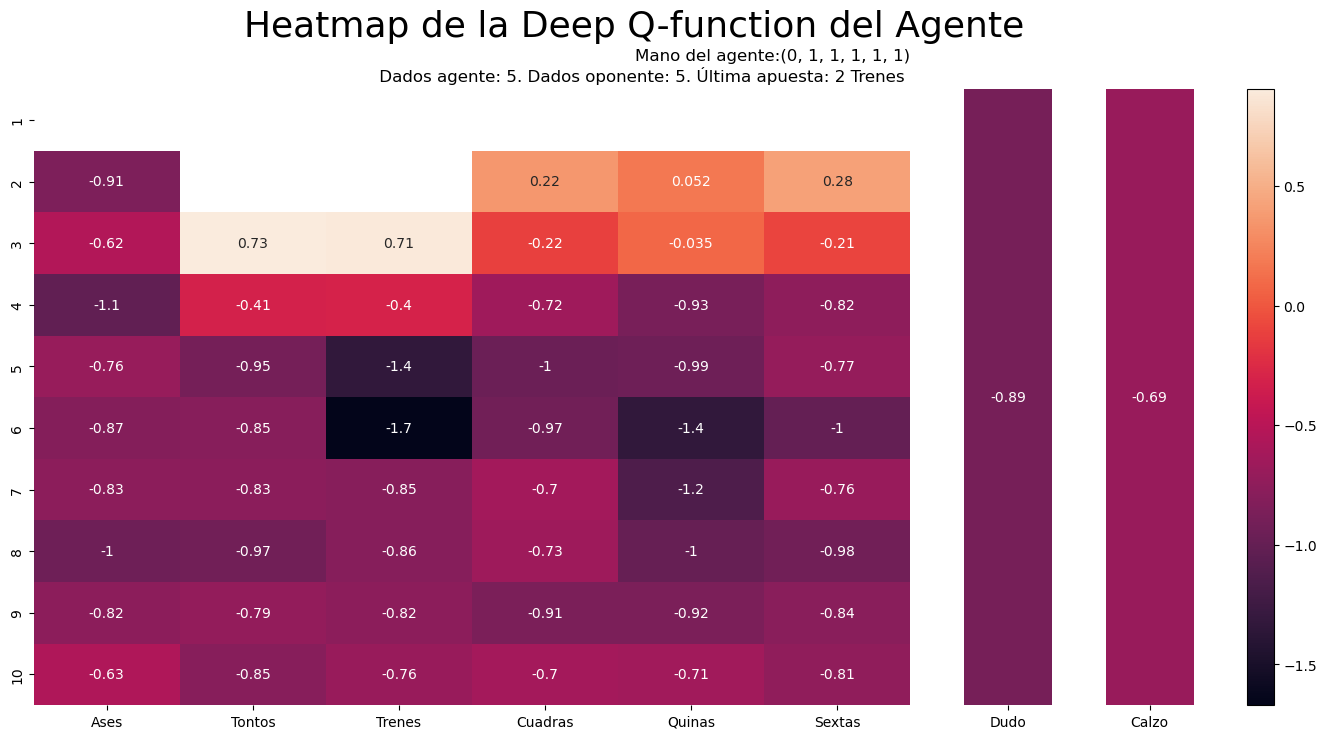

In [33]:
Q_plot(agente_DQN, ((0,1,1,1,1,1),(5,5), (2, "Trenes")), tabular = False)

In [34]:
agente_DQN.save("..\\models\\QNetwork_{}eps_{}dec.pt".format(n_games, epsdecay))

In [ ]:
agente_DQN2 = Agent(gamma=gamma, epsilon=0.01, batch_size=64, game_env=game_env, eps_end=0.01, input_dims=[10], lr=lr)
agente_DQN2.load("..\\models\\QNetwork_{}eps_{}dec.pt".format(n_games, epsdecay))

In [ ]:
play_one_game(game_env, agente_DQN2, verbose = True, graphs = True, tabular = False)

cachar sobre un error que me dio al correr esto con 10000

In [ ]:
scores, eps_hist, times = train_over_games_DQN(game_env, agente_DQN2, n_games, TARGET_UPDATE = 100000, verbose =True)
print(np.mean(scores))
scores_dict["Deep QLearning"] = winrate_every(scores, every)
times_dict["Deep QLearning"] = times
epsilon_dict["Deep QLearning"] = eps_hist

In [ ]:
df_wr = pd.DataFrame(scores_dict)
df_times = pd.DataFrame(times_dict)
df_epsilons = pd.DataFrame(epsilon_dict)

plot_winrate(df_wr, every)
plot_time_per_game(df_times, m = every)
print(df_times.mean())
plot_epsilon(df_epsilons, m = every)

In [ ]:
Q_plot(agente_DQN2, ((0,0,0,1,1,1),(3,1), (1, "Trenes")), tabular = False)

## Ejemplo Usando Gym (to delete)

In [ ]:
env = gym.make('LunarLander-v2')
agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=4, eps_end=0.01,
              input_dims=[8], lr=0.001)
scores, eps_history = [], []
n_games = 50
TARGET_UPDATE = 10
cntt = 0

for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, 
                                observation_, done)
        agent.learn()
        observation = observation_
        cntt +=1
        # Update the target network, copying all weights and biases in DQN
        if cntt % TARGET_UPDATE == 0:
            agent.Q_target.load_state_dict(agent.Q_eval.state_dict())
    scores.append(score)
    eps_history.append(agent.epsilon)

    avg_score = np.mean(scores[-100:])

    print('episode ', i, 'score %.2f' % score,
            'average score %.2f' % avg_score,
            'epsilon %.2f' % agent.epsilon)
x = [i+1 for i in range(n_games)]
filename = 'lunar_lander.png'
plotLearning(x, scores, eps_history, filename)


# TO DO (Trabajo a futuro):

- Pantalla interactiva clickeable usando Tkinter (https://docs.python.org/es/3/library/tkinter.html, https://stackoverflow.com/questions/24236058/how-to-use-looping-in-tkinter)
- Test jugando contra la optimal policy (entrenar vs agente entrenado)
- Implementar Expected Sarsa
- Ampliar a más de 2 jugadores
- Agregar el historial de la ronda como variable
- Testear policy gradients